In [1]:
from mqdq import utils, babble, ngrams

import numpy as np
import pandas as pd
import scipy as sp

import glob
import umap

from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.neighbors import KNeighborsClassifier

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
collection = []

# Several lines need to be manually deleted, because when we make wide vectors
# we treat couplets as a unit (so we must have a matching number of H and P.)
# In some poems, we have corrupt lines, and so we delete the H that matches
# a corrupt P and vice versa.

ep = babble.bookbabs('corpus/OV-epis.xml', name="Ep.")
for b in ep:
    b.author = 'Ovid'
collection.extend(ep)

tr = babble.multi_bookbabs(sorted(glob.glob('corpus/OV-tri*.xml')), name="Tr.")
for b in tr:
    b.author = 'Ovid'
collection.extend(tr)

am = babble.multi_bookbabs(sorted(glob.glob('corpus/OV-amo*.xml')), name="Am.")
for b in am:
    b.author = 'Ovid'
collection.extend(am)

tib = babble.multi_bookbabs(sorted(glob.glob('corpus/TIB-ele*.xml')), name="Tib.")
del tib[1].raw_source[24]
for b in tib:
    b.author = 'Tibullus'
collection.extend(tib)

prop = babble.multi_bookbabs(sorted(glob.glob('corpus/PROP-ele*.xml')), name="Prop.")
for b in prop:
    b.author = 'Propertius'
del prop[55].raw_source[28]
collection.extend(prop)

cat = babble.bookbabs('corpus/CATVLL-carm.xml', name="Cat.")
cat_ele = [x for x in cat if x.elegiac and len(x) > 20]
for b in cat_ele:
    b.author = 'Catullus'
del cat_ele[3].raw_source[46]
collection.extend(cat_ele)

pon = babble.multi_bookbabs(sorted(glob.glob('corpus/OV-pon*.xml')), name="Pont.")
for b in pon:
    b.author = 'Ovid'
del pon[1].raw_source[8]
del pon[7].raw_source[18]
collection.extend(pon)


In [4]:
%load_ext rpy2.ipython

# Preprocessing - Text Conversion

For this analysis the vectorisation is a little different
to the poetic analysis. The first step is to convert each
poem into a string and perform phonetic conversion. Named
Entity Removal is not done. In the case of the Heroides,
each poem (or each pair, in the Double letters) uses a different
set of characters, so there is little risk that poems might be artificially
clustered with the Heroides simply because of Named Entities.

In [5]:
# the +_just stringify+ method is from my MQDQParser library.

def vectorise_babs(babs):
    vecs = []
    for b in babs:
        v=pd.DataFrame()
        v['Chunk'] = [''.join(ngrams._just_stringify(b.raw_source, type='phon'))]
        v.insert(0, 'Poem', b.name)
        v.insert(0, 'Work', b.name.split(' ')[0])
        if hasattr(b,'author'):
            v.insert(0, 'Author', b.author)
        vecs.append(v)
    df = pd.concat(vecs)
    df.reset_index(drop=True,inplace=True)
    return df

In [6]:
# Now everything is nicely lowercased with punctuation
# stripped, but retaining linebreaks. Phonetic conversion
# has also been done.

vecs = vectorise_babs(collection)
vecs.insert(3, 'LEN', [len(b) for b in collection])
vecs

,Author,Work,Poem,LEN,Chunk
0,Ovid,Ep.,Ep. 1,116,hank tua penelope lento tibi mittit ulikse\nni...
1,Ovid,Ep.,Ep. 2,148,hospita demopoon tua te rodopeia pyllis\nultra...
2,Ovid,Ep.,Ep. 3,154,kwam legis a rapta briseide littera wenit\nwik...
3,Ovid,Ep.,Ep. 4,176,kwam nisi tu dederis karitura_st ipsa salutem\...
4,Ovid,Ep.,Ep. 5,158,perlegis an konjunks prohibet nowa perlege non...
...,...,...,...,...,...
273,Ovid,Pont.,Pont. 4 12,50,kwo minus in nostris ponaris amike libellis\nn...
274,Ovid,Pont.,Pont. 4 13,50,o mihi non dubios inter memorande sodales\nkwi...
275,Ovid,Pont.,Pont. 4 14,62,haek tibi mittuntur kwem sum modo karmine kwes...
276,Ovid,Pont.,Pont. 4 15,42,sikwis adhuk uskwam nostri non immemor ekstat\...


# Cluster Analysis, using LSA data

Now we filter poems shorter than 20 lines (only 8 works) and then do LSA. This involves:
1. Performing TF-IDF vectorisation, using 2-, 3-, and 4-grams
2. Reducing this high-dimensional data to 50 dimensions using SVD
3. Normalizing the resulting vectors

The process is fairly standard. 50 dimensions is somewhat arbitrary, but is the 'usual' number.

In [7]:
corpus = vecs[vecs.LEN >= 20]

In [8]:
p = make_pipeline(
    TfidfVectorizer(sublinear_tf=True, use_idf=True, norm='l2', analyzer='char', ngram_range=(2,4)),
    TruncatedSVD(50, random_state=42),
    Normalizer()
)
lsa_data = p.fit_transform(corpus.Chunk)

# Projection Methods

These are Figs 4(b) and 4(c). Both UMAP and t-SNE attempt to produce a 2D figure in which the local manifold properties of the high dimensional space is preserved. In other words, points that are _locally_ 'near' in the original feature space (43 dimensions) should end up locally 'near' in the projection, however the overall topology is somewhat arbitrary; points should cluster correctly, but the distribution of the clusters across the 2D figure may not reflect the true inter-cluster distances. UMAP more or less 'just works' while t-SNE has a `perplexity` parameter which affects the tightness of the clusters (sometimes it is described as broadly analagous to the _k_ in _k_ nearest neighbours.

Neither of these projections produce a result where distances are easy to understand statistically, and so they are qualitative methods (no _P_-values here!).

In [9]:
# Project the TF-IDF points down to 2D

# Most of this is fairly standard, but the set_op_mix_ratio parameter is a little
# unusual. This is the UMAP author's recommendation for outlier detection:
# https://umap-learn.readthedocs.io/en/latest/outliers.html

umap_results = corpus.copy()

umapper = umap.UMAP(
    n_neighbors=15,
    # project to 2 dimensions
    n_components=2,
    min_dist=0.4,
    set_op_mix_ratio=0.25,
    metric='euclidean',
    # UMAP figures change with every run if not seeded
    random_state=42
)

u = umapper.fit_transform(lsa_data)
umap_results['X'], umap_results['Y'] =  u[:,0], u[:,1]

# Now we have an X-Y coordinate applied to every chunk

umap_results

,Author,Work,Poem,LEN,Chunk,X,Y
0,Ovid,Ep.,Ep. 1,116,hank tua penelope lento tibi mittit ulikse\nni...,9.161843,3.036757
1,Ovid,Ep.,Ep. 2,148,hospita demopoon tua te rodopeia pyllis\nultra...,8.891693,3.225049
2,Ovid,Ep.,Ep. 3,154,kwam legis a rapta briseide littera wenit\nwik...,9.318800,2.713454
3,Ovid,Ep.,Ep. 4,176,kwam nisi tu dederis karitura_st ipsa salutem\...,8.312485,2.213334
4,Ovid,Ep.,Ep. 5,158,perlegis an konjunks prohibet nowa perlege non...,8.535680,2.773028
...,...,...,...,...,...,...,...
273,Ovid,Pont.,Pont. 4 12,50,kwo minus in nostris ponaris amike libellis\nn...,9.670907,8.651772
274,Ovid,Pont.,Pont. 4 13,50,o mihi non dubios inter memorande sodales\nkwi...,8.859253,7.515968
275,Ovid,Pont.,Pont. 4 14,62,haek tibi mittuntur kwem sum modo karmine kwes...,8.785131,7.531723
276,Ovid,Pont.,Pont. 4 15,42,sikwis adhuk uskwam nostri non immemor ekstat\...,8.979741,8.208768


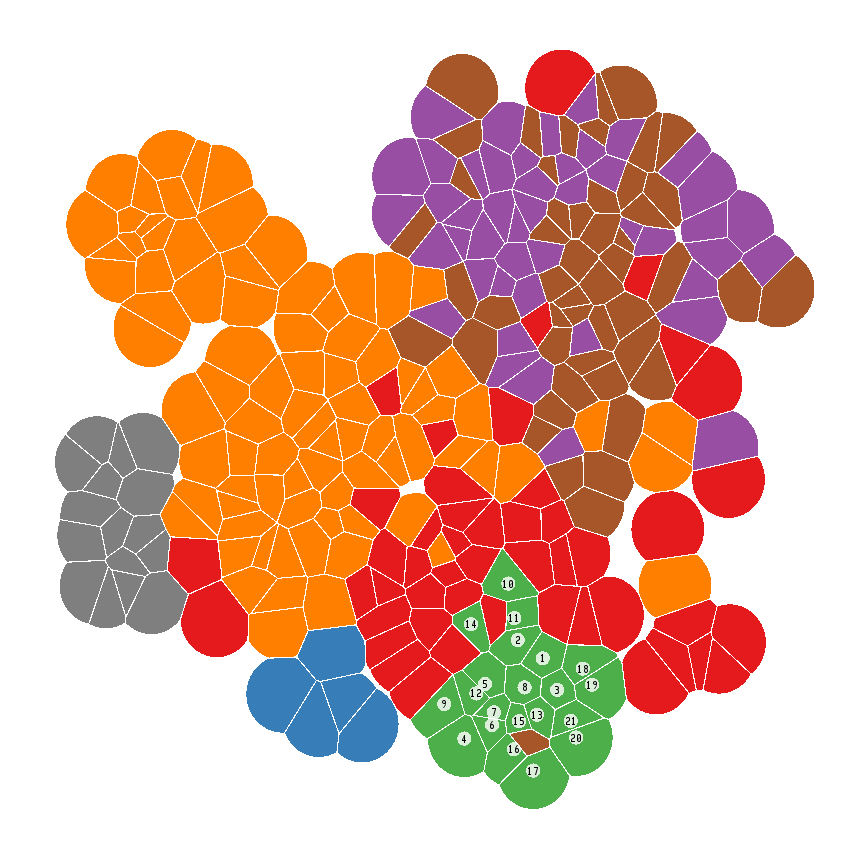

In [10]:
%%capture --no-display
%%R -i umap_results -h 6 -w 6 -u in -r 144

library(ggforce)
library(ggsci)
library(dplyr)
library(stringr)
library(extrafont)

pal <- c("#E41A1C", "#377EB8", "#4DAF4A", "#984EA3", "#FF7F00", 'grey50', "#A65628")

ep <- umap_results %>% 
    filter(Work=='Ep.') %>%
    mutate(Num = str_extract(Poem, "[0-9]+"))
    
ggplot(data=umap_results,aes(x=X, y=Y)) +
# Voronoi tesselation for everything
geom_voronoi_tile(
    aes(fill = Work, group = -1L, ),
    max.radius = 0.4,
    expand = unit(-0.1, 'mm'), 
    radius = unit(0.1, 'mm')
) +
# Add numbered points just for the Heroides
geom_point(data=ep,color='white',alpha=0.8, size=3,shape=16) +
geom_text(data=ep,aes(label=Num),family='Envy Code R',size=2) +

scale_fill_manual(values=pal) +
theme_minimal() +

theme(
    panel.border = element_blank(),
    legend.position='none',
    axis.title.x=element_blank(),
    axis.text.x=element_blank(),
    axis.ticks.x=element_blank(),
    axis.title.y=element_blank(),
    axis.text.y=element_blank(),
    axis.ticks.y=element_blank(),
    text=element_text(size=30, family="Envy Code R"),
    panel.grid.minor=element_blank(),
    panel.grid.major=element_blank()
)

# fn <- "/Users/ben/silius/ep15/ele_ngrams_umap.pdf"
# ggsave(fn, dpi=600, height=6, width=6)
# embed_fonts(fn)
# system(sprintf("pdfcrop %s", fn))

In [1]:
# Do the TSNE projection. TSNE needs dimension reduction done first
# or it goes nuts.

tsne_results = corpus.copy()
t = TSNE(
    n_components=2,
    # Using 16.31 (sqrt(observations)) compresses
    # the clusters too much in this case, t-SNE is
    # always a bit of a guessing game like that
    perplexity=16.31,
    random_state=42
).fit_transform(lsa_data)
tsne_results['X'], tsne_results['Y'] =  t[:,0], t[:,1]


NameError: name 'corpus' is not defined

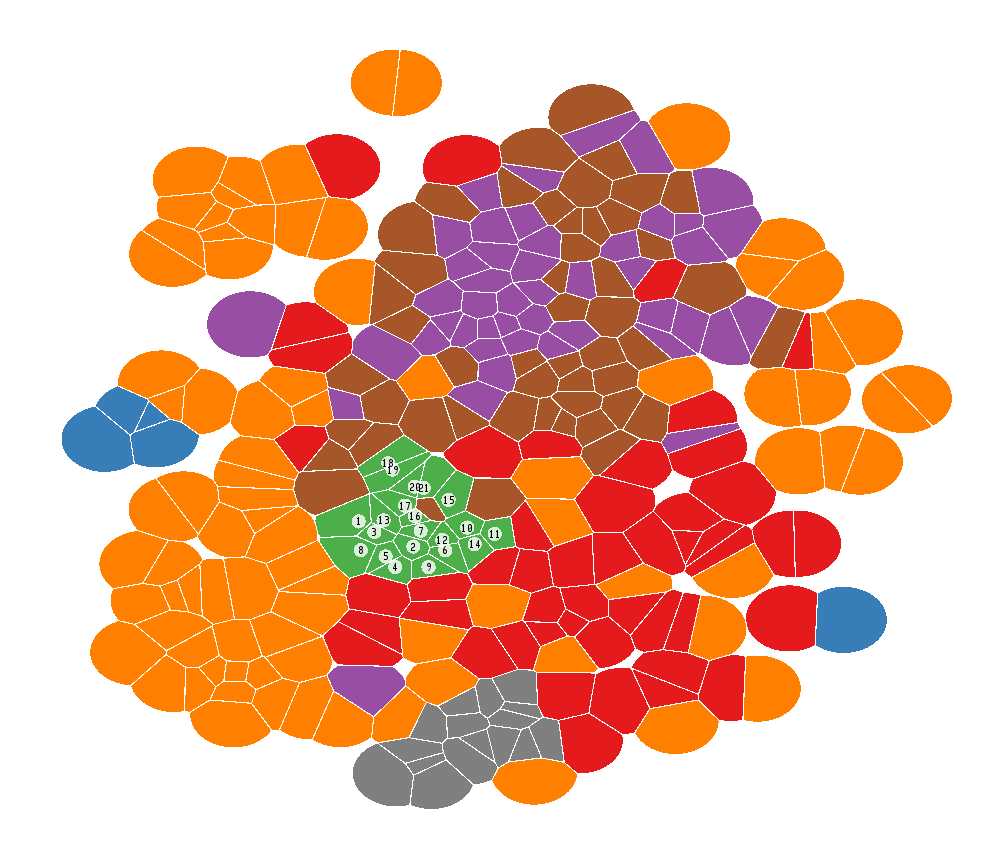

In [12]:
%%capture --no-display
%%R -i tsne_results -h 6 -w 7 -u in -r 144

pal <- c("#E41A1C", "#377EB8", "#4DAF4A", "#984EA3", "#FF7F00", 'grey50', "#A65628")

ep <- tsne_results %>% 
    filter(Work=='Ep.') %>%
    mutate(Num = str_extract(Poem, "[0-9]+"))
    
ggplot(data=tsne_results,aes(x=X, y=Y)) +
# Voronoi tesselation for everything
geom_voronoi_tile(aes(fill = Work, group = -1L, ), max.radius = 3,
                    colour = NA, expand = unit(-0.1, 'mm'), 
                    radius = unit(0.1, 'mm')) +
# Add numbered points just for the Heroides
geom_point(data=ep,color='white',alpha=0.8, size=3,shape=16) +
geom_text(data=ep,aes(label=Num),family='Envy Code R',size=2)+

scale_fill_manual(values=pal) +
theme_minimal() +

theme(
    panel.border = element_blank(),
    legend.position='none',
    axis.title.x=element_blank(),
    axis.text.x=element_blank(),
    axis.ticks.x=element_blank(),
    axis.title.y=element_blank(),
    axis.text.y=element_blank(),
    axis.ticks.y=element_blank(),
    text=element_text(size=30, family="Envy Code R"),
    panel.grid.minor=element_blank(),
    panel.grid.major=element_blank()
)

# fn <- "/Users/ben/silius/ep15/ele_ngrams_tsne.pdf"
# ggsave(fn, dpi=600, height=6, width=6)
# embed_fonts(fn)
# system(sprintf("pdfcrop %s", fn))

# Bootstrap Consensus Tree

For the idea, see Maciej Eder, (2017) Visualization in stylometry: Cluster analysis using networks, Digital Scholarship in the Humanities, 32 (1), Pages 50–64, https://doi.org/10.1093/llc/fqv061, and see also the implementation in R Stylo. The previous visualisations project from high dimensional _position_ (from the LSA data in 50 dimensions) to 2D. This method constructs many kNN trees from feature subsets, with each tree giving the closest three nodes artificial weights (3, 2, 1). The trees are then aggregated, with the idea that neighbours that are truly related will be close in many of the subset feature universes. The final layout is artificial. Users of `stylo` tend to use Gephi and ForceAtlas2, but in this case I use Fruchterman-Reingold (more or less the same idea) which can be easily done in R with `ggraph`. Once the consensus tree is trimmed, it could be laid out with many different algorithms, and the results are broadly similar (the point positions may change slightly but the overall topological implications don't vary). The advantage of this BCT method is that is shows the strength of the relationships as well as the determined positions.


In [13]:
df = pd.DataFrame(lsa_data)
X,y = df, list(corpus.Poem)

In [14]:
dfs = []
rng = np.random.RandomState(seed=42)
for _ in range(500):
    
    # Sample 15 random features (columns)
    this_X = X.sample(15,axis=1,random_state=rng)
    
    # Calculate kNN in that space
    cl = KNeighborsClassifier(n_neighbors=3, metric='cosine')
    cl.fit(this_X,y)
    dists,indices = cl.kneighbors(n_neighbors=3)
    
    # And build a dataframe from the results
    dicts = []
    for i, node_ary in enumerate(indices):
        for j, node in enumerate(node_ary):
            dicts.append({
                'from': y[i],
                'to': y[node],
                # neighbors are sorted low distance to high
                # so this gives us the 'inverse rank' ie lowest
                # distance of n neighbors scores n, next is n-1 etc
                # this is consistent with the stylo BCT algorithm
                'weight': (len(node_ary)-j)
            })
    dfs.append(pd.DataFrame(dicts))

# Now aggregate the dataframes, summing the weights for 
# identical (directed) edges
graph = pd.concat(dfs).groupby(['from','to'],as_index=False).agg(sum)
graph_trim=graph.nlargest(int(len(graph)*0.2),'weight')

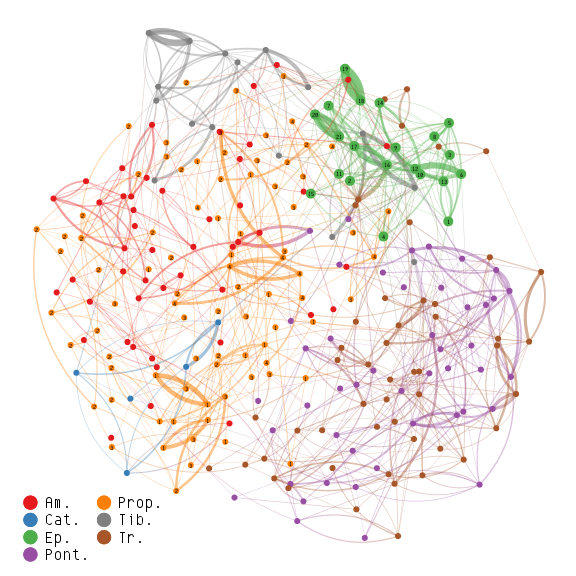

R[write to console]: Warning message:

R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages



In [15]:
%%capture --no-display
%%R -i graph_trim  -h 8 -w 8 -u in -r 72

# other libraries only need to be loaded once
library(ggraph)
library(tidygraph)

pal <- c("#E41A1C", "#377EB8", "#4DAF4A", "#984EA3", "#FF7F00", "grey50", "#A65628")

# Seed for the layout
set.seed(42)
gr1 <- as_tbl_graph(graph_trim)
# Plot
gr1 %>%
    # Add a node attribute called 'work' which is the poem name with
    # no numbers eg Pont. 3 4 -> Pont.
    activate(nodes) %>%
    mutate(work = str_replace_all(name, '\\s[0-9]+', '')) %>%
    # Layout with Fruchtermann Reingold
    ggraph(layout = 'fr') + 
    # fan2 does curved lines when nodes are linked in both directions
    # and also lets you interpolate colour along the edge
    geom_edge_fan2(
        aes(
            # Aesthetically filter out noisy minor edges.
            # This magic param is determined by experimentation
            # and depends on the number of samples etc.
            # Slightly hacky, but doesn't affect graph layout,
            # just makes the visualisation cleaner.
            filter=weight>=120,
            width=weight,
            color=node.work,
            alpha=weight
        ),
        strength=2,
        show.legend=FALSE
    ) +
    # Normal nodes
    geom_node_point(size = 2.2, aes(color = work), alpha=1) +
    # Number Heroides and Propertius with the first number that
    # follows the name. For Prop. this is the book number, for Ep.
    # it is the letter number (it's not divided into books)
    geom_node_point(aes(filter=work=='Ep.',color=work),size=4) +
    geom_node_text(
        size = 2,
        family="Envy Code R",
        aes(filter=work %in% c('Ep.','Prop.'),label=str_extract(name,'\\d+')),
    ) +
    
    scale_fill_manual(values=pal) +
    scale_color_manual(values=pal) +
    scale_edge_color_manual(values=pal) +
    scale_edge_width(range=c(0.2,4)) +
    scale_edge_alpha(range=c(0.3,1)) +
    
    guides(color=guide_legend(ncol=2, override.aes = aes(label="",size=6))) +

    theme_minimal() +
    theme(
        plot.title = element_text(margin = margin(b = 50)),
        panel.border = element_blank(),
        legend.title=element_blank(),
        legend.position= c(0.15, 0.07),
        legend.text=element_text(size=16),
        legend.spacing.x = unit(2, 'mm'),
        legend.spacing.y = unit(0.1, 'mm'),
        axis.title.x=element_blank(),
        axis.text.x=element_blank(),
        axis.ticks.x=element_blank(),
        axis.title.y=element_blank(),
        axis.text.y=element_blank(),
        axis.ticks.y=element_blank(),
        text=element_text(family="Envy Code R"),
        panel.grid.minor=element_blank(),
        panel.grid.major=element_blank()
    )

# fn <- "/Users/ben/silius/ep15/ele_ngrams_bct.pdf"
# ggsave(fn, dpi=600, height=8, width=8)
# embed_fonts(fn)
# system(sprintf("pdfcrop %s", fn))